**Condor Instruments** - Non-parametric sleep variables

*Julius A. P. P. de Paula*

*jp@condorinst.com.br* 



*   If you would like, you can access a Google Colab version of this page at: https://drive.google.com/file/d/1RNw0plSeb1EuYmeUmicRITA97OXtPA8T/view?usp=sharing

In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
from glob import glob
init_notebook_mode(connected = True)

In [ ]:
def actigraphy_load_data(filename):
    f = open(filename, "r")
    count = 0
    while count < 50:
        count += 1

        # Get next line from file
        line = f.readline()
        if '+-------------------------------------------------------+' in line:
            break
    df = pd.read_csv(filename, delimiter = ';', header = count, parse_dates = False)
    df['DATE/TIME'] = pd.to_datetime(df['DATE/TIME'], format = '%d/%m/%Y %H:%M:%S')
    df.set_index( df['DATE/TIME'], inplace = True)
    return df   

def actigraphy_select_period(start_date, end_date):
    index = np.logical_and(df.index >= start_date, df.index < end_date)
    filtered_df = df[index]
    return filtered_df

def actigraphy_split_by_day(df, start_hour = 0):
    ldays = []
    ldays_ref = []
    
    #First day is the start of the day of the first Epoch
    sdate = pd.Timestamp(year = df.index[0].year, month = df.index[0].month, day = df.index[0].day)
    if(df.index[0].hour <= start_hour):
        sdate = sdate - pd.Timedelta(hours = start_hour) 
    else:
        sdate = sdate + pd.Timedelta(hours = start_hour)         
    
    while sdate < df.index[-1]:
        day = np.logical_and(df.index >= sdate, df.index < sdate + pd.Timedelta(hours = 24))
        ldays.append(df[day])
        ldays_ref.append(pd.Timestamp(year = sdate.year, month = sdate.month, day = sdate.day))
        sdate += pd.Timedelta(hours = 24)
    days_df = pd.DataFrame()
    days_df['DAY'] = ldays_ref
    days_df['DATAFRAME'] = ldays
    return days_df

In [ ]:
filename = "Example_Log.txt"
url ='https://github.com/Condor-Instruments/actigraphy-tutorials-sample/blob/master/Example_Log.txt?raw=true'
urllib.request.urlretrieve(url, filename)

df = actigraphy_load_data(filename)

start_date = pd.Timestamp('2015-12-26 00:00:00')
end_date = df.index[-1]
df = actigraphy_select_period(start_date,end_date)

In [ ]:
def actigraphy_calculate_L5(df_in, channel, remove_offwrist = True):
    df = df_in.copy()
    if(remove_offwrist):
        df[df['STATE']== 4] = np.nan
    i = 0
    start = df.index[i]
    end = start + pd.Timedelta(hours = 5)
    L5 = np.inf
    L5_onset = df.index[0]
    while end <= df.index[-1] and i < len(df):

        index = np.logical_and(df.index>=start, df.index < end)
        five_hours_average = np.nanmean(df[index][channel])
        if five_hours_average < L5:
            L5 = five_hours_average
            L5_onset = start
        i += 1
        start = df.index[i]
        end = start + pd.Timedelta(hours = 5)
    return L5, L5_onset

def actigraphy_calculate_M10(df_in, channel, remove_offwrist = True):
    df = df_in.copy()
    if(remove_offwrist):
        df[df['STATE']== 4] = np.nan
    i = 0
    start = df.index[i]
    end = start + pd.Timedelta(hours = 10)
    M10 = 0
    M10_onset = df.index[0]
    while end <= df.index[-1] and i < len(df):
        index = np.logical_and(df.index>=start, df.index < end)
        ten_hours_average = np.nanmean(df[index][channel])
        if ten_hours_average > M10:
            M10 = ten_hours_average
            M10_onset = start
        i += 1
        start = df.index[i]
        end = start + pd.Timedelta(hours = 10)
    return M10, M10_onset

def actigraphy_calculate_IV(df_in, channel, remove_offwrist = True):
    df = df_in.copy()
    if(remove_offwrist):
        df[df['STATE']== 4] = np.nan
    ldf = df.copy()
    ldf['HOUR'] = ldf.index.hour
    ldf['DAY'] = ldf.index.date
    sumdf = ldf.groupby(['DAY', 'HOUR']).mean()
    diffval = sumdf[channel].diff().dropna()
    muldiff = diffval.multiply(diffval).sum()*len(sumdf)
    diffvalden = sumdf[channel]-sumdf[channel].mean()
    muldiffden = diffvalden.multiply(diffvalden).sum()*(len(sumdf)-1)
    
    return muldiff/muldiffden

def actigraphy_calculate_IS(df_in, channel, remove_offwrist = True):
    df = df_in.copy()
    if(remove_offwrist):
        df[df['STATE']== 4] = np.nan
    ldf = df.copy()
    ldf['HOUR'] = ldf.index.hour
    ldf['DAY'] = ldf.index.date
    sumdfhour = ldf.groupby(['HOUR']).mean()
    sumdf = ldf.groupby(['DAY', 'HOUR']).mean()
    num = sumdfhour[channel] - sumdf[channel].mean()
    mulnum = num.multiply(num).sum()*len(sumdf)
    den = sumdf[channel] - sumdf[channel].mean()
    mulden = den.multiply(den).sum()*len(sumdfhour)

    return mulnum/mulden

In [ ]:
actigraphy_calculate_L5(df,'PIM')

(36.87, Timestamp('2016-01-01 21:26:26'))

In [ ]:
actigraphy_calculate_M10(df,'PIM')

(5965.236666666667, Timestamp('2015-12-28 05:24:26'))

In [ ]:
ldays = actigraphy_split_by_day(df, start_hour = 0)

In [ ]:
result_df = pd.DataFrame()
M10_list = []
M10_onset_list = []
L5_list = []
L5_onset_list = []
IV_list = []
for d in ldays['DATAFRAME']:
    L5, L5_onset = actigraphy_calculate_L5(d,'PIM')
    M10, M10_onset = actigraphy_calculate_M10(d,'PIM')
    M10_list.append(M10)
    M10_onset_list.append(M10_onset)
    L5_list.append(L5)
    L5_onset_list.append(L5_onset)
    IV_list.append(actigraphy_calculate_IV(d,'PIM'))
    
result_df['M10'] = M10_list
result_df['M10_onset'] = M10_onset_list
result_df['L5'] = L5_list
result_df['L5_onset'] = L5_onset_list
result_df['IV'] = IV_list

In [ ]:
result_df['DAY'] = ldays['DAY']

In [ ]:
def actigraphy_calculate_average_day(df, epoch):
    resample_df = df.resample(str(epoch)+'S').mean()
    resample_df['HOUR'] = resample_df.index.hour
    resample_df['DAY'] = resample_df.index.date
    resample_df['SECOND'] = resample_df.index.second
    resample_df['MINUTE'] = resample_df.index.minute
    avg_day = resample_df.groupby(['HOUR', 'MINUTE', 'SECOND']).mean()
    H = avg_day.index.get_level_values(0).to_numpy()
    M = avg_day.index.get_level_values(1).to_numpy()
    S = avg_day.index.get_level_values(2).to_numpy()
    avg_day['AVGTIME'] = pd.to_datetime(H*3600+M*60+S,unit='s')
    avg_day.set_index('AVGTIME', inplace = True)
    return avg_day
    

In [ ]:
avg_day = actigraphy_calculate_average_day(df, 60)

In [ ]:
first_day = avg_day
second_day = avg_day.copy()
second_day.index += pd.Timedelta(days = 1)
two_average_day = first_day.append(second_day)

In [ ]:
L5, L5_onset = actigraphy_calculate_L5(two_average_day,'PIM')
M10, M10_onset = actigraphy_calculate_M10(two_average_day,'PIM')

In [ ]:
print("L5: ", L5)
print("L5_onset: ", L5_onset)
print("M10: ", M10)
print("M10_onset: ", M10_onset)

L5:  213.31146520146518
L5_onset:  1970-01-01 23:50:00
M10:  3768.17
M10_onset:  1970-01-01 06:50:00


In [ ]:
L5, L5_onset = actigraphy_calculate_L5(avg_day,'PIM')
M10, M10_onset = actigraphy_calculate_M10(avg_day,'PIM')

In [ ]:
print("L5: ", L5)
print("L5_onset: ", L5_onset)
print("M10: ", M10)
print("M10_onset: ", M10_onset)

L5:  234.74309523809526
L5_onset:  1970-01-01 00:01:00
M10:  3768.17
M10_onset:  1970-01-01 06:50:00


In [ ]:
actigraphy_calculate_IS(df,'PIM')

0.5295099996202268

In [ ]:
actigraphy_calculate_IV(df,'PIM')

0.840738936284457

In [ ]:
L5, L5_onset = actigraphy_calculate_L5(ldays.iloc[2]['DATAFRAME'],'PIM')

In [ ]:
loglist = [df]

Example_Log.txt
Example_Log2.txt


In [ ]:
len(loglist)

2

In [ ]:
result_df = pd.DataFrame()
M10_list = []
M10_onset_list = []
L5_list = []
L5_onset_list = []
two_average_day_list = []

for l in loglist:
    avg_day = actigraphy_calculate_average_day(l, 60)
    first_day = avg_day
    second_day = avg_day.copy()
    second_day.index += pd.Timedelta(days = 1)
    two_average_day = first_day.append(second_day)
    L5, L5_onset = actigraphy_calculate_L5(two_average_day,'PIM')
    M10, M10_onset = actigraphy_calculate_M10(two_average_day,'PIM')
    M10_list.append(M10)
    M10_onset_list.append(M10_onset)
    L5_list.append(L5)
    L5_onset_list.append(L5_onset)
    two_average_day_list.append(two_average_day)
    
    
result_df['M10'] = M10_list
result_df['M10_onset'] = M10_onset_list
result_df['L5'] = L5_list
result_df['L5_onset'] = L5_onset_list
print(result_df)

result_df['data'] = two_average_day_list

           M10           M10_onset          L5            L5_onset
0  3289.950034 1970-01-01 07:06:00  324.275419 1970-01-01 23:50:00
1  3074.736083 1970-01-01 12:26:00  397.183833 1970-01-01 02:05:00


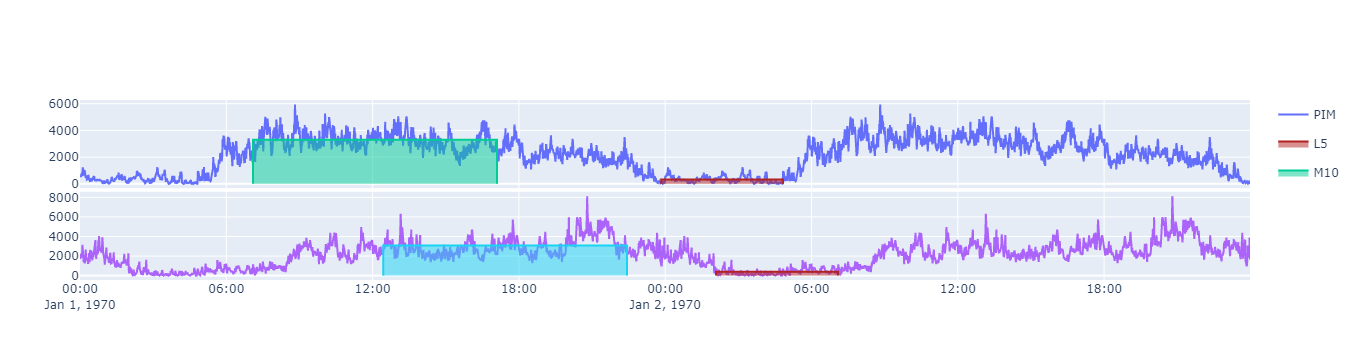

In [ ]:
fig = make_subplots(rows=len(result_df), cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.02)
for index in range(len(result_df)):
    L5_onset = result_df['L5_onset'][index]
    if(L5_onset < pd.to_datetime('1970-01-01 12:00')):
        L5_onset += pd.Timedelta(hours = 24)
    L5_end = L5_onset+pd.Timedelta(hours = 5)
    L5 = result_df['L5'][index]

    M10_onset = result_df['M10_onset'][index]
    M10_end = (result_df['M10_onset']+pd.Timedelta(hours = 10))[index]
    M10 = result_df['M10'][index]
    if index == 0:
        show_legend = True
    else:
        show_legend = False
    fig.add_trace(go.Scatter(x=result_df['data'][index].index, y=result_df['data'][index]['PIM'], name = 'PIM', legendgroup='groupPIM',
                showlegend=show_legend), row = index+1, col = 1)
    fig.add_trace(go.Scatter(x=[L5_onset, L5_onset, L5_end, L5_end], y=[0, L5, L5, 0], fill='tozeroy', name = 'L5', mode = 'lines', legendgroup='groupL5',
                showlegend=show_legend, line=dict(color='firebrick')), row = index+1, col = 1)
    fig.add_trace(go.Scatter(x=[M10_onset, M10_onset, M10_end, M10_end], y=[0, M10, M10, 0], fill='tozeroy', name = 'M10', mode = 'lines', legendgroup='groupM10',
                showlegend=show_legend), row = index+1, col = 1)
fig.show()